In [ ]:
!pip install feedparser
!pip install nltk
!pip install wordcloud
!pip install matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 2.5 MB/s eta 0:00:00
  Created wheel for sgmllib3k: filename=sgmllib3k-1.0.0-py3-none-any.whl size=6046 sha256=cedee08b28356889a8fb5182398b3d9ef28fbe06e43ab3019452e6e2a7c22070
  Stored in directory: /root/.cache/pip/wheels/3b/25/2a/105d6a15df6914f4d15047691c6c28f9052cc1173e40285d03
Successfully built sgmllib3k


In [ ]:
# =============================================================================
# Section 1: Importing Necessary Libraries
# =============================================================================

import feedparser             # To retrieve and parse RSS feeds for news data.
import pandas as pd           # For data manipulation and analysis.
import nltk                   # For various NLP functions like tokenizing and lemmatization.
import re                     # For regex operations (e.g., cleaning HTML tags).
import string                 # For operations on punctuation.
from nltk.corpus import stopwords        # To get a list of stopwords for cleaning text.
from nltk.stem import WordNetLemmatizer    # For reducing words to their base form.
from collections import Counter          # To count word frequencies.
import matplotlib.pyplot as plt          # For all visualizations.
from wordcloud import WordCloud          # For generating a word cloud visualization.

# Download necessary NLTK datasets if not already available.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# =============================================================================
# Section 2: Retrieving Financial News via RSS Feed
# =============================================================================


import requests  # For making HTTP requests to the NewsAPI endpoint

# ----------------------------------------------------------------------
# Define your API key and the endpoint URL for NewsAPI:
# ----------------------------------------------------------------------
api_key = '555a630757264dfe91011283370def9a'  # Replace with your NewsAPI key
url = f'https://newsapi.org/v2/top-headlines?category=business&language=en&apiKey={api_key}'

def retrieve_newsapi_news(url, max_entries=10):
    """
    Retrieve business news articles using the NewsAPI endpoint.

    Parameters:
        url (str): The NewsAPI endpoint URL.
        max_entries (int): Maximum number of articles to retrieve.

    Returns:
        news_articles (list): A list of dictionaries, each containing:
            - 'title': The news article headline.
            - 'description': A brief summary of the article.
            - 'url': The direct URL to the full article.
            - 'publishedAt': Publication date and time in ISO 8601 format.
    """
    try:
        # Send GET request to the NewsAPI endpoint
        response = requests.get(url)
        # Raise an HTTPError if the API call was unsuccessful (e.g., wrong API key)
        response.raise_for_status()
    except requests.RequestException as e:
        print(f"Error retrieving news articles: {e}")
        return []

    # Convert the response from JSON into a Python dictionary.
    data = response.json()

    # Verify the API response status (NewsAPI returns "ok" if successful)
    if data.get('status') != 'ok':
        print("API returned an error:", data)
        return []

    # Extract the list of articles from the JSON data.
    articles = data.get('articles', [])

    news_articles = []
    for article in articles[:max_entries]:
        news_articles.append({
            'title': article.get('title', ''),
            'description': article.get('description', ''),
            'url': article.get('url', ''),
            'publishedAt': article.get('publishedAt', '')
        })
    return news_articles

# Use the function to retrieve a set of business news articles
news_articles = retrieve_newsapi_news(url, max_entries=10)

# Check if articles were retrieved successfully and print a summary.
if news_articles:
    print("Retrieved News Articles:")
    for article in news_articles:
        print(f"- {article['title']} (Published at: {article['publishedAt']})")
else:
    print("No articles were retrieved. Please check your API key and URL.")


Retrieved News Articles:
- European stocks plunge 3% as Trump's reciprocal tariffs take effect - CNBC (Published at: 2025-04-09T08:31:00Z)
- US tariffs cause car import pile-up at American ports - Financial Times (Published at: 2025-04-09T04:01:32Z)
- Trump says ‘major’ pharmaceutical tariffs on the way - Politico (Published at: 2025-04-09T02:51:08Z)
- White House says iPhones can be made in the U.S. It won’t be easy. - The Washington Post (Published at: 2025-04-09T02:04:08Z)
- Trump’s Tariffs Put Fed Chair Powell in a ‘No-Win Situation’ - WSJ (Published at: 2025-04-09T00:00:00Z)
- Prime minister confirms new UK Universal theme park in Bedford - BBC (Published at: 2025-04-08T23:23:54Z)
- These companies — or their leaders — donated to Trump's inauguration. Here's how much their share prices have dropped since then. - Business Insider (Published at: 2025-04-08T22:26:00Z)
- Justice Department will disband its crypto-related enforcement team - AP News (Published at: 2025-04-08T21:44:00Z)


In [ ]:
# Convert the list of news entries to a DataFrame for easier inspection and manipulation.
df_news = pd.DataFrame(news_articles)
print("Retrieved News Articles:")
print(df_news.head())

Retrieved News Articles:
                                               title  \
0  European stocks plunge 3% as Trump's reciproca...   
1  US tariffs cause car import pile-up at America...   
2  Trump says ‘major’ pharmaceutical tariffs on t...   
3  White House says iPhones can be made in the U....   
4  Trump’s Tariffs Put Fed Chair Powell in a ‘No-...   

                                         description  \
0  European stocks traded lower on Wednesday, wit...   
1  Executive warns situation could become ‘quite ...   
2  He predicted the move would bring drug manufac...   
3  Consumers are rushing to buy iPhones before th...   
4  A trade war ties the Fed’s hands by pushing up...   

                                                 url           publishedAt  
0  https://www.cnbc.com/2025/04/09/european-marke...  2025-04-09T08:31:00Z  
1  https://www.ft.com/content/dca52e46-cd51-4325-...  2025-04-09T04:01:32Z  
2  https://www.politico.com/news/2025/04/08/trump...  2025-04-09T02:51

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# =============================================================================
# Section 3: Preprocessing the Text Data
# =============================================================================

def preprocess_text(text):
    """
    Preprocess a text string by:
      - Converting to lowercase.
      - Removing HTML tags.
      - Removing punctuation.
      - Tokenizing the text.
      - Removing stopwords.
      - Lemmatizing tokens.
      - Reassembling tokens into a cleaned string.

    Parameters:
        text (str): The raw text to preprocess.

    Returns:
        processed_text (str): The cleaned text ready for NLP analysis.
    """
    # 1. Convert text to lowercase to standardize it.
    text = text.lower()

    # 2. Remove any HTML tags that may be present.
    text = re.sub(r'<.*?>', ' ', text)

    # 3. Remove punctuation using a translation table.
    text = text.translate(str.maketrans('', '', string.punctuation))

    # 4. Tokenize the text using NLTK's word_tokenize.
    tokens = nltk.word_tokenize(text)

    # 5. Filter out common English stopwords.
    stop_words = set(stopwords.words('english'))
    tokens = [token for token in tokens if token not in stop_words]

    # 6. Lemmatize tokens (reduce words to their base form).
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    # 7. Reassemble the cleaned tokens back into a single string.
    processed_text = ' '.join(tokens)
    return processed_text

# Create a new DataFrame column that combines the title and description,
# which enriches the context for processing.
df_news['combined_text'] = df_news['title'] + " " + df_news['description']

# Apply the preprocessing function to the combined text.
df_news['processed_text'] = df_news['combined_text'].apply(preprocess_text)

print("\nPreprocessed Text of the First News Article:")
print(df_news['processed_text'].iloc[0])


Preprocessed Text of the First News Article:
european stock plunge 3 trump reciprocal tariff take effect cnbc european stock traded lower wednesday market struggling maintain tuesday positive momentum



Top 10 Most Common Words:
[('’', 9), ('tariff', 7), ('trump', 6), ('u', 4), ('price', 4), ('stock', 3), ('‘', 3), ('say', 3), ('company', 3), ('oil', 3)]


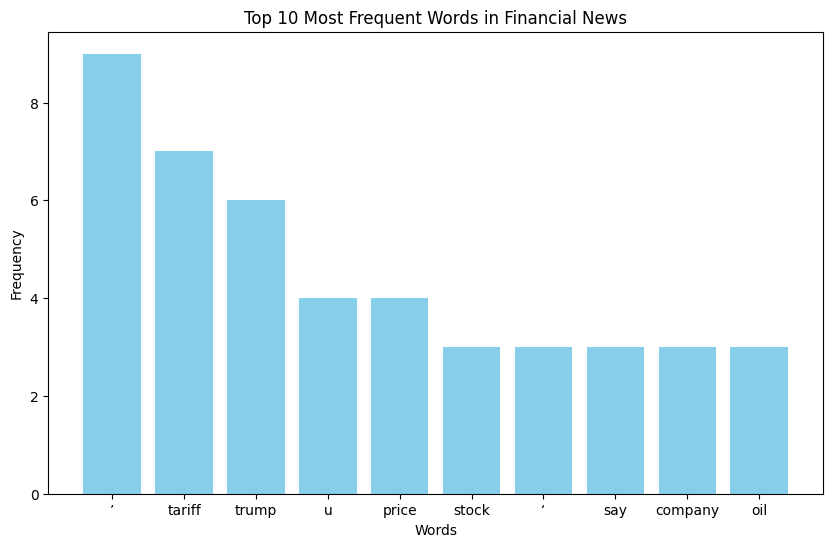

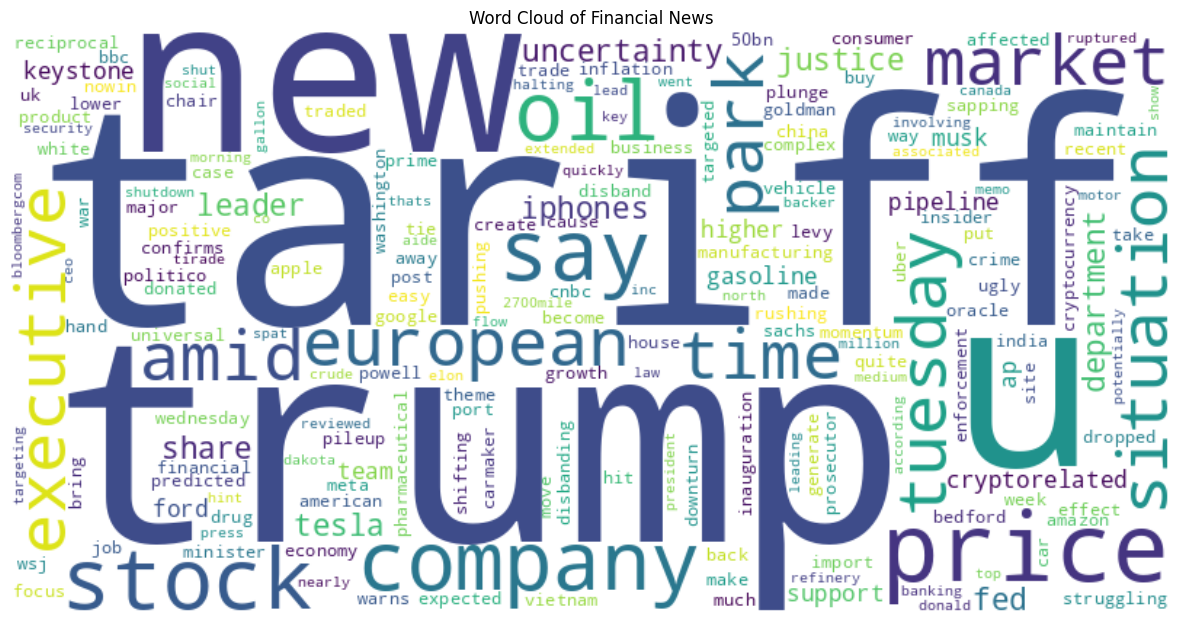

In [ ]:
# =============================================================================
# Section 4: Exploratory Data Analysis (EDA) & Visualization
# =============================================================================

def get_word_frequencies(text_series):
    """
    Compute word frequency counts for a pandas Series containing text.

    Parameters:
        text_series (pd.Series): Series with preprocessed text.

    Returns:
        word_freq (Counter): A collection mapping words to their counts.
    """
    # Concatenate all text entries into one large string.
    all_text = ' '.join(text_series)
    # Split the text by whitespace to get individual tokens.
    tokens = all_text.split()
    # Count the frequency of each token.
    word_freq = Counter(tokens)
    return word_freq

# Compute word frequencies across all preprocessed news articles.
word_freq = get_word_frequencies(df_news['processed_text'])

# Print the top 10 most common words.
most_common_words = word_freq.most_common(10)
print("\nTop 10 Most Common Words:")
print(most_common_words)

# ---------------------------
# Visualization 1: Bar Chart
# ---------------------------
def plot_top_words(word_freq, n=10):
    """
    Plot a bar chart showing the top 'n' most frequent words.

    Parameters:
        word_freq (Counter): A Counter object with word frequencies.
        n (int): Number of top words to display in the chart.
    """
    common_words = word_freq.most_common(n)
    words = [word for word, freq in common_words]
    frequencies = [freq for word, freq in common_words]

    plt.figure(figsize=(10, 6))
    plt.bar(words, frequencies, color='skyblue')
    plt.xlabel('Words')
    plt.ylabel('Frequency')
    plt.title(f'Top {n} Most Frequent Words in Financial News')
    plt.show()

# Generate and display the bar chart.
plot_top_words(word_freq, n=10)

# ---------------------------
# Visualization 2: Word Cloud
# ---------------------------
def plot_word_cloud(text_series):
    """
    Generate and display a word cloud based on the text series.

    Parameters:
        text_series (pd.Series): Series containing the preprocessed text.
    """
    all_text = ' '.join(text_series)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)

    plt.figure(figsize=(15, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Word Cloud of Financial News')
    plt.show()

# Generate and display the word cloud.
plot_word_cloud(df_news['processed_text'])

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


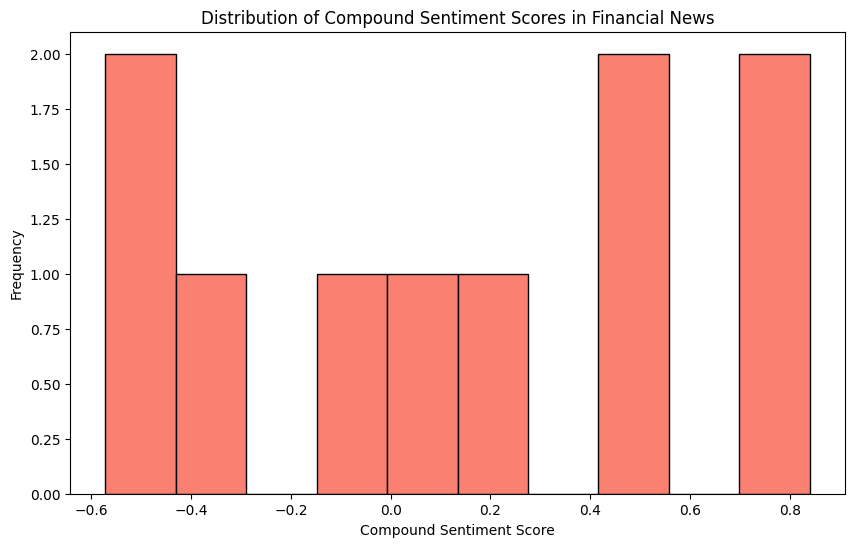

In [ ]:
# =============================================================================
# Section 5: Optional – Sentiment Analysis (Using NLTK's VADER)
# =============================================================================
# The following lines can be uncommented if you wish to extend the codebook
# to include sentiment analysis on the financial news.

from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

def analyze_sentiment(text):
    """
    Analyze the sentiment of the given text using VADER.

    Parameters:
        text (str): The text to analyze.

    Returns:
        sentiment (dict): A dictionary containing sentiment intensity scores.
    """
    sia = SentimentIntensityAnalyzer()
    sentiment = sia.polarity_scores(text)
    return sentiment

# Apply sentiment analysis to the combined text and store the results.
df_news['sentiment'] = df_news['combined_text'].apply(analyze_sentiment)
# Extract the compound sentiment score (a summary sentiment metric).
df_news['compound'] = df_news['sentiment'].apply(lambda x: x['compound'])

# Visualization 3: Histogram of Compound Sentiment Scores
plt.figure(figsize=(10, 6))
plt.hist(df_news['compound'], bins=10, color='salmon', edgecolor='black')
plt.xlabel('Compound Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Compound Sentiment Scores in Financial News')
plt.show()
